# Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import warnings
warnings.filterwarnings('ignore')

# Equations

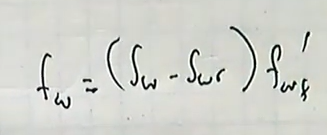

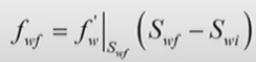

# Boundary conditions

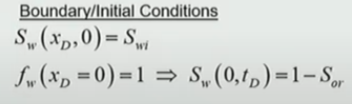

# Code implementation

--------------------------------------------------
Front water Saturation: 0.417924917404818
Front dimensionless x: 0.144588526104447
td: 0.04
--------------------------------------------------
Front water Saturation: 0.417924917404818
Front dimensionless x: 0.289177052208894
td: 0.08
--------------------------------------------------
Front water Saturation: 0.417924917404818
Front dimensionless x: 0.433765578313341
td: 0.12
--------------------------------------------------
Front water Saturation: 0.417924917404818
Front dimensionless x: 0.578354104417788
td: 0.16
Breakthrough time: -->  0.276647124621113


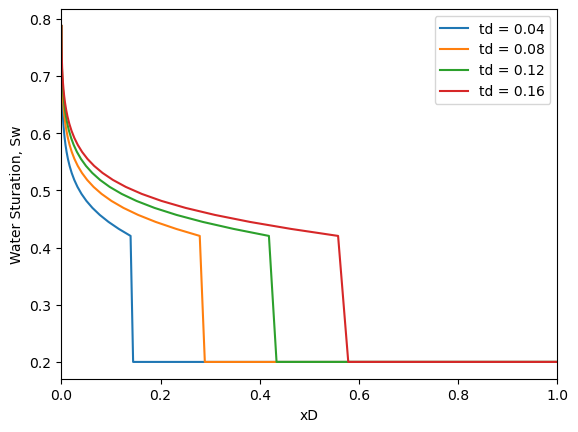

In [3]:
class Buckley_Leveret:
    
    def __init__(self, Swirr, Swinit, Sor, mu_o, mu_w, N=50):
        self.N = N
        self.Sor = Sor
        self.Sw = np.linspace(Swirr, 1-self.Sor, self.N)
        self.Swirr = Swirr
        self.Swinit = Swinit
        self.mu_o = mu_o
        self.mu_w = mu_w
    
    def calculate_fwd(self, fw, Sw, Sw_symbol):
        dfw_dS = sp.diff(fw, Sw_symbol)
        gfunc = sp.lambdify(Sw_symbol, dfw_dS, "numpy")
        return dfw_dS, gfunc(Sw)

    def calculate_fractional_flow(self, Sw):
        S = (Sw-self.Swirr)/(1-self.Swirr-self.Swinit)
        k_rw = 0.2*S**3
        k_ro = (1-S)**3
        self.Mo = (k_rw*self.mu_o)/(k_ro*self.mu_w)
        fw = self.Mo/(1+self.Mo)
        self.fw = fw
        return self.fw
    
    def calculate_front_saturation(self, Q_w, A, L, phi, t):
        Sw = sp.Symbol('Sw')
        self.Sw_symbol = Sw
        S = (Sw - self.Swirr) / (1 - self.Swirr - self.Swinit)
        k_rw = 0.2 * S**3
        k_ro = (1 - S)**3
        Mo = (k_rw * self.mu_o) / (k_ro * self.mu_w)
        fw1_expr = Mo / (1 + Mo)

        fw_d_func = self.calculate_fwd(Sw_symbol=Sw, fw=fw1_expr, Sw=self.Sw)
        fw_d_expr = fw_d_func[0]
        fw2_expr = (Sw - self.Swirr) * fw_d_expr
        fw_d = fw_d_func[1]
        # Find intersection points by solving fw1 = fw2
        intersection_points = sp.solve(sp.Eq(fw1_expr, fw2_expr), Sw)

        self.fw1_expr = fw1_expr
        self.fw2_expr = fw2_expr

        self.td = Q_w*t/A*phi
        
        self.Swf = intersection_points[1]
        self.xdf = self.td*self.calculate_fwd(Sw_symbol=Sw, fw=fw1_expr, Sw=self.Swf)[1]
        print("Front water Saturation:", self.Swf)
        print("Front dimensionless x:", self.xdf)

        self.intersection_points = intersection_points
        self.xd = fw_d*self.td

        return self.Swf, self.xdf, self.xd, fw_d, self.td
    
    def calculate_tbt(self):
        self.tbt = 1/self.calculate_fwd(fw=self.fw1_expr, Sw=self.Swf, Sw_symbol=self.Sw_symbol)[1]
        return self.tbt

    def Sw_xd_profile(self, Swf, xdf, Sw, xd):
        Sw = np.append(Sw, Swf)
        Sw = np.sort(Sw) 
        Sw = np.flip(Sw)
        xd = np.flip(xd)
        idx = np.where(Sw == Swf)[0][0]
        xd = np.insert(xd, idx, xdf)
        xd = np.delete(xd, np.s_[idx:])
        Sw = np.delete(Sw, np.s_[idx:])
        Sw = np.append(Sw, self.Swinit)
        xd = np.append(xd, xdf)
        Sw = np.append(Sw, self.Swinit)
        xd = np.append(xd, 1)
        return Sw, xd
    
Swirr = 0.2
Swinit = 0.2

mu_o = 10
mu_w = 0.1
Sor = 0.2

t = 0.5
Q_w = 1000
A = 2500
L = 1000
phi = 0.2

while t<=2:
    print('-'*50)
    Buckley = Buckley_Leveret(Swirr=Swirr, Swinit=Swinit, Sor=Sor, mu_o=mu_o, mu_w=mu_w)
    fw = Buckley.calculate_fractional_flow(Buckley.Sw)
    Swf, xdf, xd, fw_d, td= Buckley.calculate_front_saturation(Q_w=Q_w, A=2500, L=1000, phi=0.2, t=t)
    print(f'{"td: {:.2f}".format(td)}')
    Sw, xd = Buckley.Sw_xd_profile(Swf, xdf, Buckley.Sw, xd)
    plt.plot(xd, Sw, label=f'td = {"{:.2f}".format(td)}')
    plt.ylabel('Water Sturation, Sw')
    plt.xlabel('xD')
    plt.legend()
    plt.xlim(0,1)
    t += 0.5
print('Breakthrough time: --> ', Buckley.calculate_tbt())

# Plots

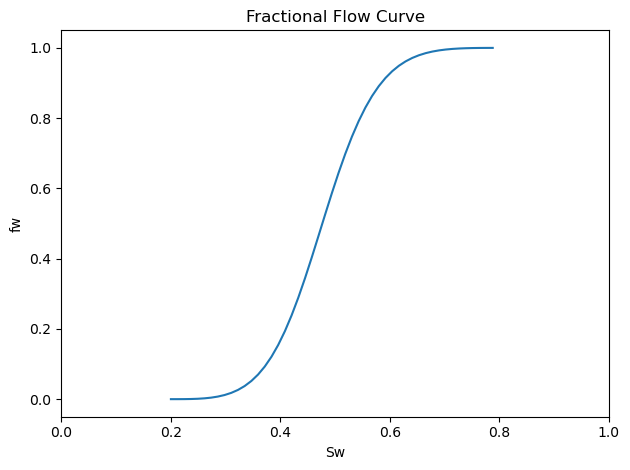

In [3]:
plt.plot(Buckley.Sw, fw)
plt.ylabel('fw')
plt.xlabel('Sw')
plt.title('Fractional Flow Curve')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

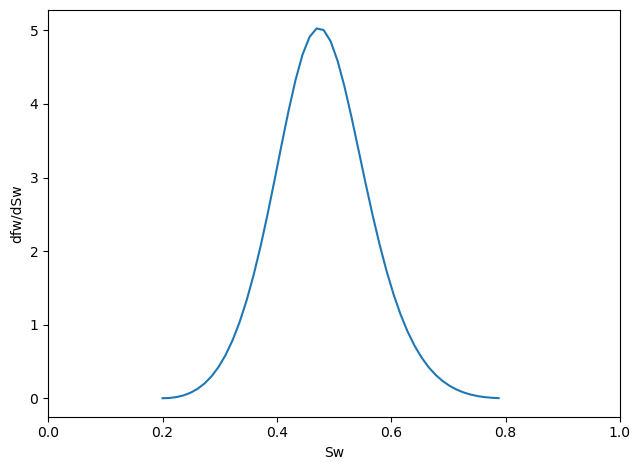

In [4]:
plt.plot(Buckley.Sw, fw_d)
plt.ylabel('dfw/dSw')
plt.xlabel('Sw')
plt.tight_layout()
plt.xlim(0,1)
plt.show()

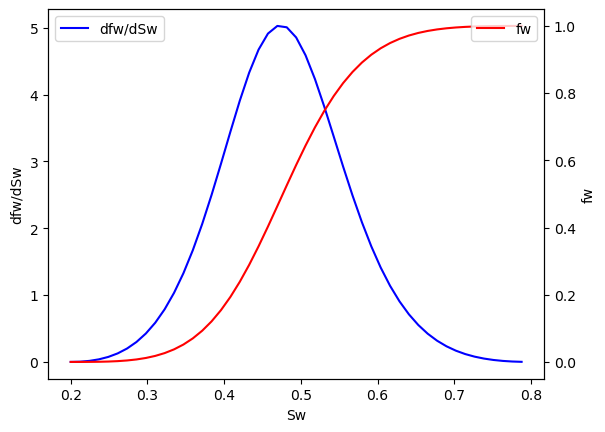

In [5]:
# Create figure and first axis
fig, ax1 = plt.subplots()

# Plot the first data on the left axis
ax1.plot(Buckley.Sw, fw_d, 'b-', label='dfw/dSw')

# Create a second axis on the right
ax2 = ax1.twinx()

# Plot the second data on the right axis
ax2.plot(Buckley.Sw, fw, 'r-', label='fw')

ax1.set_ylabel('dfw/dSw')
ax2.set_ylabel('fw')
ax1.set_xlabel('Sw')
# Add legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.show()

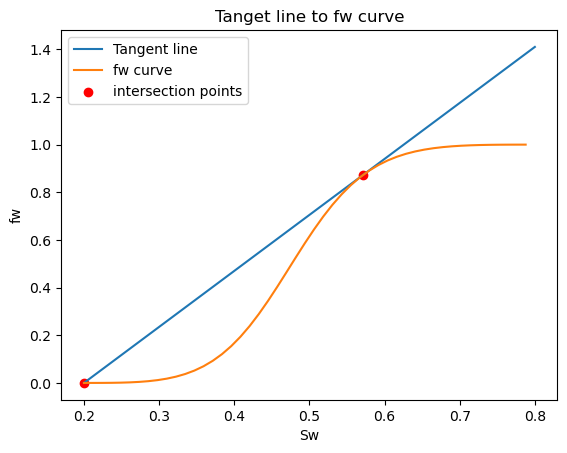

In [8]:
fwf_d = Buckley.calculate_fwd(Buckley.fw1_expr, Swf, Buckley.Sw_symbol)[1]
fw_ = (Buckley.Sw-Swirr)*fwf_d
plt.plot(Buckley.Sw, fw_, label='Tangent line')
plt.plot(Buckley.Sw, fw, label='fw curve')
plt.scatter(Buckley.intersection_points[0], Buckley.calculate_fractional_flow(Buckley.intersection_points[0]), color='red', label='intersection points')
plt.scatter(Buckley.intersection_points[1], Buckley.calculate_fractional_flow(Buckley.intersection_points[1]), color='red')
plt.title('Tanget line to fw curve')
plt.xlabel('Sw')
plt.ylabel('fw')
plt.legend()
plt.show()

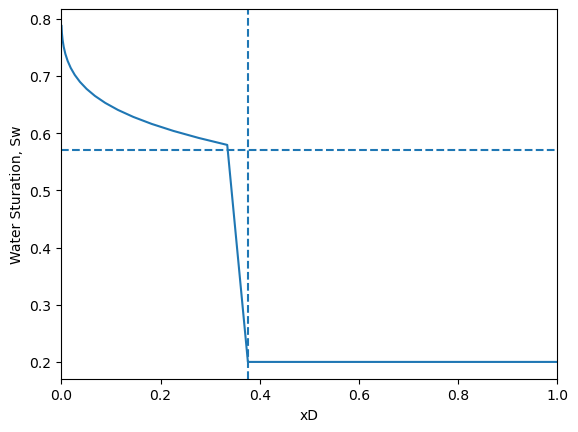

In [7]:
plt.plot(xd, Sw)
plt.ylabel('Water Sturation, Sw')
plt.xlabel('xD')
plt.xlim(0,1)
plt.axvline(xdf, linestyle='--')
plt.axhline(Swf, linestyle='--')
plt.show()

# Conclusion

In this Jupyter notebook, we have demonstrated several key aspects regarding the behavior of fractional water flow with respect to water saturation:

1. **Fractional Water Flow Curve and Water Saturation:**  
   We successfully implemented the visualization of how the fractional water flow curve changes with variations in water saturation.

2. **Derivative Plot:**  
   We plotted the derivative of fractional water flow with respect to saturation, providing insight into the rate of change of water flow behavior.

3. **Tangent Line Method:**  
   Utilizing the tangent line method, we identified intersection points on the fractional water curve. These points represent the front water saturation and corresponding dimensionless distance.

4. **Temporal Changes in Water Saturation:**  
   Lastly, we sketched the temporal evolution of water saturation with respect to distance, providing a comprehensive view of how saturation changes over time.

By exploring these aspects, we gain a deeper understanding of the dynamics of water flow in the given system, which can be valuable for various applications and analyses.
